# Перенос табличных данных с фото в csv

Комьюнити доноров крови "DonorSearch" нуждается в помощи по автоматизации переноса данных из сфотографированных донорских справок в их внутреннюю базу данных. Цель нашего проекта - помочь сообществу в их волонтёрской деятельности и облегчить работу проверяющих справки модераторов. Для реализации проекта будут использоваться библиотеки Python для взаимодействия с графикой и технологии оптического распознавания символов (OCR).

"DonorSearch" предоставили 15 фото-примеров справок. Для сохранения конфиденциальности данных, они не будут присутствовать в открытом доступе, но будут использоваться для проверки точности готового решения.

**План работы:**
1) Знакомство с данными
2) Предобработка изображений и распознавание табличных данных
4) Распознавание текста, разметка, рассчёт точности
7) Отчёт о проделанной работе

## Знакомство с данными

In [1]:
# Импорт библиотек
import os
import re
import random

import cv2
import pandas as pd
import matplotlib.pyplot as plt

from d_ocr import donation_ocr

Этот шаг проверяет целостность предоставленного датасета и собирает названия пар `.jpg` и `.csv` для последующего использования.

In [2]:
# проверка пар, сбор списка пар

rootdir = "./datasets/405/"
regex_find = re.compile('(.*csv$)|(.*jpg$)')
jpg_list = []
csv_list = []

for root, dirs, files in os.walk(rootdir):
    for file in files:
        if regex_find.match(file):
            temp = os.path.splitext(file)
            if temp[1] == '.jpg':
                name = temp[0] + temp[1]
                clean_name = temp[0].strip() + temp[1]
                if name != clean_name:
                    os.rename(rootdir+'/'+name, rootdir+'/'+clean_name) # убираем лишние пробелы в названиях фото
                jpg_list.append(temp[0])
            else: csv_list.append(temp[0])

for x in jpg_list:
    if x not in csv_list:
        print(f'Отсутствует csv для {x}.jpg')

for x in csv_list:
    if x not in jpg_list:
        print(f'Отсутствует jpg для {x}.csv')

pairs_list = list(set(jpg_list) & set(csv_list))
pairs_list.sort()

Отсутствует csv для 240493.jpg


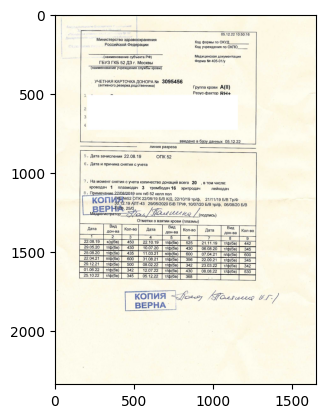

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,165015,227414,Цельная кровь,22.08.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
1,165016,227414,Тромбоциты,22.10.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
2,165017,227414,Тромбоциты,21.11.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
3,165018,227414,Тромбоциты,29.05.2020,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
4,165019,227414,Тромбоциты,10.07.2020,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да


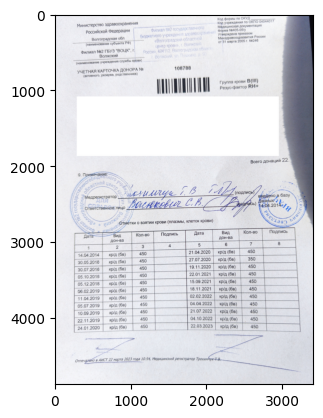

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,197529,213950,Цельная кровь,14.04.2014,23.03.2023,Безвозмездно,"Россия, Волгоградская область, Волжский",53,Принята,Да
1,197531,213950,Цельная кровь,30.05.2018,23.03.2023,Безвозмездно,"Россия, Волгоградская область, Волжский",53,Принята,Да
2,197532,213950,Цельная кровь,30.07.2018,23.03.2023,Безвозмездно,"Россия, Волгоградская область, Волжский",53,Принята,Да
3,197938,213950,Цельная кровь,05.10.2018,24.03.2023,Безвозмездно,"Россия, Волгоградская область, Волжский",53,Принята,Да
4,197939,213950,Цельная кровь,05.12.2018,24.03.2023,Безвозмездно,"Россия, Волгоградская область, Волжский",53,Принята,Да


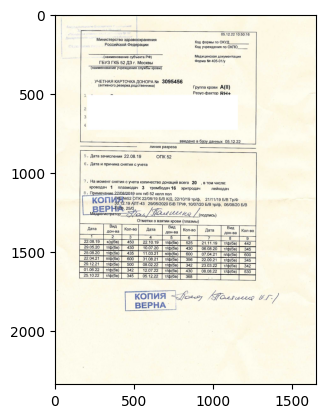

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,165015,227414,Цельная кровь,22.08.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
1,165016,227414,Тромбоциты,22.10.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
2,165017,227414,Тромбоциты,21.11.2019,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
3,165018,227414,Тромбоциты,29.05.2020,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да
4,165019,227414,Тромбоциты,10.07.2020,06.12.2022,Безвозмездно,"Россия, Москва",641,Принята,Да


In [3]:
# проверка случайно выбранного фото и эталонной таблицы

its = 3

for i in range(its):
    test = random.choice(pairs_list)
    df = pd.read_csv(rootdir+test+'.csv')
    img = cv2.imread(rootdir+test+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show();
    display(df.head())

Фото предоставленны в различном качестве и разрешении, на некоторых фото присутствуют jpg-артефакты, на некоторых фото часть синей печати медицинской организации попала на искомую таблицу.

В предоставленных csv-файлах присутствуют колонки, которые невозможно заполнить информацией с фото.

## Предобработка

Цели предобработки:
- Удаление артефактов
- Повышение читаемости текста
- Приведение изображения к форме, лучше воспринимаемой OCR


Было решено ограничить предобработку входных изображений кропом (позволяет значительно ускорить процесс распознавания текста), оставляя только нижнюю половину и не применять методы извлечения табличных данных, ограничившись разметкой через regex, т.к. процесс распознавания текста в EasyOCR включает в себя некоторую предобработку изображений.

In [4]:
def cut_in_half(image):
    
    height, width, channels = image.shape
    hei = int(height / 2)
    cut_img = image[hei: height, 0:width]
    
    return cut_img

## Распознавание текста, разметка, рассчёт точности

In [5]:
# функция рассчёта точности
def acc(y_true, y_pred):
    
    true_counter = 0

    for row_true in range(len(y_true)):
        for row_pred in range(len(y_pred)):
            if y_true.loc[row_true, 'Дата донации'] == y_pred.loc[row_pred, 'Дата донации']:
                true_temp_counter = 1
                if y_true.loc[row_true, 'Класс крови'] == y_pred.loc[row_pred, 'Класс крови']:
                    true_temp_counter += 1
                if y_true.loc[row_true, 'Тип донации'] == y_pred.loc[row_pred, 'Тип донации']:
                    true_temp_counter += 1
                true_counter += true_temp_counter/3
    return true_counter/len(y_true)

In [6]:
# инициализация easyocr
ocr = donation_ocr(cut=False)

# переменные для рассчёта точности
sum_acc = 0
iteration = 0

# перебор всех изображений с парой
for x in pairs_list:
    
    # собрать датафрейм с предсказаниями
    df_pred = ocr.predict('./datasets/405/'+x+'.jpg')

    # открыть таблицу для сравнения
    df_true = pd.read_csv('./datasets/405/'+x+'.csv')[['Класс крови', 'Дата донации', 'Тип донации']]
    
    sum_acc += acc(df_true, df_pred)
    
#рассчёт общей точности
result = sum_acc/len(pairs_list)
print('Точность =', result)

Точность = 0.5573905447468666


## Общий вывод:

Были протестированы дополнительные способы предобработки изображения с помощью библиотеки cv2, такие как:
- 1) В ходе работы были выдвинута гипотеза о том, что применение `sharpen kernel` позволит повысить читаемость фото для модели, но в ходе эксперимента было доказано обратное. 
- 2) Бинаризация с помощью adaptive Threshold  с разными способами рассчёта порогового значения также не позволила повысить точность предсказаний. 
- 3) Для устранения jpeg артефактов были протестированы методы размытия, гауссовского размытия и двусторонний фильтр, которые также негативно повлияли на качество предсказаний. 
- 4) Для удаления синих печатей был испробован метод адаптивной конвертации пикселей (из синих в белые), но это ставило новые требования к обрабатываемым фото - фото должно быть сделано при тёплом или дневном освещении и на фото не должно быть тени. Позднее было установлено, что применение такого фильтра негативно (незначительно) влияет на точность модели.
<br/><br/>
Для улучшения читаемости таблицы были проверены следующие методы:
- 1) Page-dewarp (https://github.com/mzucker/page_dewarp/) - негативное влияние на качество предсказаний.
- 2) Более новая версия page-dewarp (https://github.com/lmmx/page-dewarp) - негативное влияние на качество предсказаний.
- 3) Модель DewarpNet (https://github.com/cvlab-stonybrook/DewarpNet) - негативное влияние на качество предсказаний.
<br/><br/>
Для улучшения качества фото были протестированы следующие модели:
- 1) Bsrgan (https://github.com/cszn/BSRGAN) - негативное влияние на качество предсказаний.
- 2) Real-ESRGAN (https://github.com/xinntao/Real-ESRGAN) - негативное влияние на качество предсказаний.
- 3) SwinIR (https://github.com/JingyunLiang/SwinIR) - были протестированы модели real_sr и специально обученная на устранение jpeg артефактов color_jpeg_car. Применение real_sr повысило качество предсказаний, но значительно увеличило время обработки изображений.
<br/><br/>
Для извлечения табличных данных были протестированы следующие библиотеки: 
- 1) img2table (https://github.com/xavctn/img2table) - распознавала множество лишних ячеек, нарушала структуру таблицы, тем самым негативно влияла на качество предсказаний.
- 2) OCR_tablenet (https://github.com/tomassosorio/OCR_tablenet) - очень хорошо определяет границы таблицы, в целом хорошо распознаёт ячейки, но периодически не различала номера колонок и разбивала ячейку "Вид дон-ва" на две ячейки, нарушая тем самым структуру датафрейма с предсказанием.

Современные средства распознавания текста имеют достаточно высокую точность и просты в использовании, однако для удачного распознавания должны быть соблюдены следующие требования к фото:
1) На фото должна присутствовать вся справка целиком
2) Лист справки должен быть минимально деформирован
3) На табличных данных не должно быть печати
4) Распознаваемое изображение должно быть в хорошем качестве и не иметь jpeg-артефактов, текст легко читаем